<a href="https://colab.research.google.com/github/r-doz/PML2025/blob/main/./02_numpy_pandas_sklearn/03_intro_to_pyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 3: Introduction to **Pyro**

Probabilistic Machine Learning -- Spring 2025, UniTS

The material in this notebook is based on the [Pyro's documentation](https://pyro.ai) and from the previous work of [Emanuele Ballarin](https://ballarin.cc).

Probabilistic programming is a **programming paradigm** that allows us to describe uncertainty and randomness in our models and data. 

In traditional programming, we usually deal with **deterministic processes**, i.e. processes where *the same input always leads to the same output*, e.g. `3+5` will always return `8`. 
But in many real-world problems, we deal with uncertain data or uncertain models, and that's where probabilistic programming comes in.

Imagine you're building a weather prediction system. You have data on temperature, humidity, and pressure, but you can never be completely certain about the weather. Probabilistic programming allows you to model this uncertainty in a **precise** and **formal** way. For example, if we’re predicting the chance of rain tomorrow based on uncertain weather data, **our model will return a probability distribution**, such as a 70% chance of rain.

- **random variables:** variables that represent uncertain or random quantities (e.g. the chance of rain tomorrow) - they will assume different values based on a certain probability distribution;
- **probabilistic models:** mathematical models describing uncertainty in a system (e.g. a model that predicts whether it will rain tomorrow based on past weather data) - describes how random variables interact, often built on *bayesian statistics*;
- **inference:** the process of updating our beliefs or predictions about uncertain variables based on available data, involving algorithms like Markov Chain Monte Carlo (MCMC) or variational inference - consists in obtaining *posterior distributions*.

### Practically speaking:
Probabilistic programs combine **ordinary deterministic computation** with **randomly sampled values**, representing a generative process for data.

In general, the aim is to solve an inference problem, as "what must be true if this random variable assumed a certain observed value?", following the steps:

- Specify a model
- Identify a query to be answered
- Choose an algorithm for computing the answer

## Probabilistic models in Pyro

Pyro is a:

- **deep:** allows *automatic differentiation of primitives*, making it play well with deep learning architectures
- **universal:** allows all probabilistic programs to be *correctly expressed*.

PPL based on PyTorch. This provides efficient, flexible and scalable (up to very large datasets) automatic optimisation-based inference, GPU-accelerated tensor mathematics (as with plain PyTorch), and the ability to exploit (internally or explicitly) automatic differentiation.

In [1]:
# If you run this notebook in Colab, do not forget to (uncomment and) run:
# !pip install pyro-ppl

### Modelling / Simulation

A ***statistical model*** is a mathematical description of how some *knowns* (and what's their *form*, since they are known!) and *unknowns* (and ***how** unknown?*; see *e.g.* this [seminal work by E.T. Jaynes](https://bayes.wustl.edu/etj/articles/prior.pdf)!) generate the observed data.

The basic unit of *probabilistic programming* is a *stochastic function*, a function representing a ***generative model*** of the data indeed. In `Pyro`, any function can be viewed as a stochastic function: significantly, functions mixing deterministic Python/`PyTorch` code with *sampling primitives* are generally considered to be *proper* *stochastic function*s.

In [1]:
#SETUP: IMPORT THE MODULES WE MAY NEED
import torch
import seaborn as sns

import pyro
import pyro.distributions as dist

/home/saracandussio/.conda/envs/stdenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Sampling

In order to sample from a given distribution we use the `pyro.sample` function

In [17]:
pyro.sample(name="just_a_sample",
            fn=dist.Normal(loc=0, scale=1))

tensor(-0.3865)

In [18]:
# sampling multiple times
pyro.sample(name="other_samples",
            fn=dist.Normal(loc=0, scale=1),
            sample_shape=(10,))

tensor([-0.7983,  0.5863, -0.1324,  1.2526,  0.1988, -0.3740, -0.8898, -0.2044,
        -0.6930,  1.0193])

Pyro is based on PyTorch's tensors, one of the reasons is that many of its functionalities need automatic differentiation.

In [19]:
x_pyro = pyro.sample(name="other_samples",
            fn=dist.Normal(loc=0, scale=1),
            sample_shape=(10,))

print(f"Pyro sample: {x_pyro}; type {type(x_pyro)}")

Pyro sample: tensor([ 2.9131, -0.4978, -0.6509, -0.6660,  0.0435,  1.5870,  1.8568,  0.8107,
         0.8178,  1.9882]); type <class 'torch.Tensor'>


### Defining a model

Notice that we had to specify a name when sampling, but why is it mandatory?

The point is that `pyro.sample` is not only made for sampling (for that there are simpler functions in `torch` or `numpy`), but under the hood it also keeps track of the random variables with their given names, and in general of the full generative process!

To exploit this feature we have to 'enclose' all `pyro.sample` calls inside a function that we define, representing the generative process (the model), for example:

In [20]:
def my_model():
    x = pyro.sample("x", dist.Bernoulli(0.3))
    pyro.sample("y", dist.Normal(x, 1))

The `my_model` function now represents a model of a stochastic process, in this case:

$$X \sim Bern(0.3)$$
$$Y \sim \mathcal{N}(X, 1)$$

or in other words
$$p(x,y) = p(x)p(y|x) \ \ \text{where:}$$
$$p(x) = Bern(x; 0.3)$$
$$p(y|x) \sim \mathcal{N}(y | \mu = x, \sigma = 1)$$

Pyro has functions that can take `my_model` as input and do very useful things.

This is an example of one of these functionalities: we can plot the graphical model representing the stochastic process we defined:

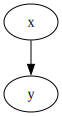

In [23]:
pyro.render_model(my_model)

# For this you need to install graphviz:
# sudo apt install graphviz
# pip install graphviz

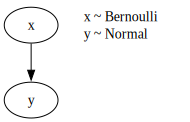

In [24]:
pyro.render_model(my_model, render_distributions=True)

Plotting a Bayesian network is not the most useful thing you can do with pyro, but it shows you that pyro is able to understand the model from the code you write inside a function. 

**Inference** is actually the point of using a PPL as pyro, but in this lesson we will mostly limit ourselves to sampling, since you have still to learn about **approximate inference**.

**Example: the *exam grade stochastic model***

A **very false** (but probably didactically useful) model for the grade of an exam is the following:

The grade of an exam (in tenths) depends on the difficulty of the exam and on the knowledge of the student, according to the following model:

$$\text{difficulty}\sim\text{Bern(0.5)}$$  
$$\text{knowledge}\sim\text{Bern(0.3)}$$  
$$\text{grade} \sim \mathcal{N}(\mu = 4\cdot\text{knowledge}-2\cdot\text{difficulty}+4,\sigma = 1)$$  

We can easily implement this model in `Pyro`:

In [25]:
def describe_grade():
    difficulty = pyro.sample("exam", dist.Bernoulli(0.5))
    is_hard = "hard" if difficulty.item() == 1.0 else "easy"

    knowledge = pyro.sample("knowledge", dist.Bernoulli(0.3))
    is_knowledgeable = "knowledgeable" if knowledge.item() == 1.0 else "not knowledg."

    mu = 4 * knowledge - 2 * difficulty + 4
    grade = pyro.sample("grade", dist.Normal(loc=mu, scale=1))

    print(f"{is_hard} exam + {is_knowledgeable} student -> grade = {grade}")

for _ in range(10):
    describe_grade()

easy exam + not knowledg. student -> grade = 4.361023426055908
easy exam + knowledgeable student -> grade = 8.219879150390625
hard exam + knowledgeable student -> grade = 6.540139675140381
easy exam + not knowledg. student -> grade = 4.118636608123779
easy exam + knowledgeable student -> grade = 8.587127685546875
hard exam + knowledgeable student -> grade = 6.136934280395508
hard exam + not knowledg. student -> grade = 2.412254571914673
hard exam + knowledgeable student -> grade = 5.792545318603516
easy exam + not knowledg. student -> grade = 3.146474599838257
easy exam + knowledgeable student -> grade = 8.733067512512207


We can use pyro to plot the bayesian net corresponding to a model we defined.:

hard exam + not knowledg. student -> grade = 2.0584044456481934


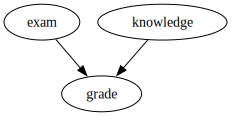

In [26]:
pyro.render_model(describe_grade)

We can also compute the likelihood of samples:

In [30]:
def compute_likelihood(model, *args):
    return torch.exp(pyro.poutine.trace(model).get_trace(*args).log_prob_sum()).item()

print('sample likelihood:', compute_likelihood(describe_grade))

easy exam + not knowledg. student -> grade = 2.6978259086608887
sample likelihood: 0.05980958417057991


This is probably not really useful by itself, but the possibility to compute the likelihood is fundamental for most inference techniques (just think about maximum likelihood estimation).

**Example: weather**

In [32]:
def weather():# -> dict[str, Any]:
    is_cloudy = pyro.sample("cloudy", dist.Bernoulli(0.3))
    weather = "cloudy" if is_cloudy.item() == 1.0 else "sunny"
    
    loc_temp = 12.0 if weather == "cloudy" else 23.00
    scale_temp = 5.0 if weather == "cloudy" else 6.00
    temp = pyro.sample("temp", dist.Normal(loc_temp, scale_temp))
    return {"weather": weather, "temp": temp.item()}

for _ in range(5):
    print(weather())

{'weather': 'cloudy', 'temp': 11.343801498413086}
{'weather': 'cloudy', 'temp': 11.696417808532715}
{'weather': 'sunny', 'temp': 26.37136459350586}
{'weather': 'sunny', 'temp': 28.519710540771484}
{'weather': 'sunny', 'temp': 26.019596099853516}


Additionally, we could use this stochastic function to model the sales of ice cream based on the weather.

In [34]:
def ice_cream_sales():
    is_cloudy, temp = weather()
    expected_sales = 200.0 if (is_cloudy == 1 and temp > 35.0) else 20.0
    sales = pyro.sample("ice_cream", pyro.distributions.HalfNormal(expected_sales, 10.0))
    return sales.item()

for _ in range(5):
    print(ice_cream_sales())

25.463397979736328
23.79159164428711
13.573902130126953
1.4839608669281006
33.592628479003906


This represents the following model
$$p(\text{cloudy}, \text{temp}, \text{ice cream sales}) = p(\text{ice cream sales} |  \text{temp}, \text{cloudy})p( \text{temp} | \text{cloudy})p(\text{cloudy})$$
We can find any marginal as $p(\text{ice cream sales})$ by simulation (instead of by marginalization). It is sufficient to get enough samples and look at the histogram of ice_cream_sales:

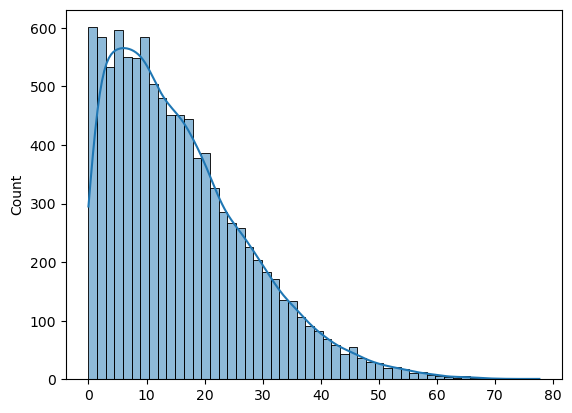

In [35]:
n = 10_000
samples = [ice_cream_sales() for _ in range(n)]
_ = sns.histplot(samples, kde=True)

Quite slow, right?

### Observed values

Let's consider again the exam grade model. 

The `pyro.sample` method accepts also a `obs` argument, this can be used to tell the model that you have observed a value for that random variable. As a result of this, the output will be exactly the given observations (unless `obs=None`). What's the point of this? Again, this is something useful for **inference**, but here we can just check that pyro is able to recognize it.

In [47]:
def describe_grade(obs=None):
    difficulty = pyro.sample("exam", dist.Bernoulli(0.5))
    is_hard = "hard" if difficulty.item() == 1.0 else "easy"

    knowledge = pyro.sample("knowledge", dist.Bernoulli(0.3))
    is_knowledgeable = "knowledgeable" if knowledge.item() == 1.0 else "not knowledg."

    mu = 4 * knowledge - 2 * difficulty + 4
    grade = pyro.sample("grade", dist.Normal(loc=mu, scale=1), obs=obs) # HERE!

    print(f"{is_hard} exam + {is_knowledgeable} student -> grade = {grade}")

describe_grade()

hard exam + not knowledg. student -> grade = 3.524592161178589


hard exam + knowledgeable student -> grade = 5.8415141105651855


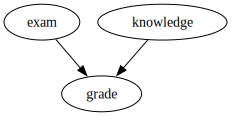

In [37]:
pyro.render_model(describe_grade) #obs is None by default

easy exam + not knowledg. student -> grade = 10.0


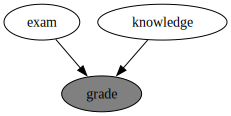

In [48]:
pyro.render_model(describe_grade, model_args=(torch.tensor(10.0),))

Sampling doesn't make sense anymore, since the value of the observed variable is fixed, but the other random variables don't change accordingly!

In [49]:
describe_grade(obs=None) # this is ok

easy exam + not knowledg. student -> grade = 4.520711898803711


In [50]:
describe_grade(obs=torch.tensor(60.0)) # this is not ok, you can see the warning (max = 10)

easy exam + knowledgeable student -> grade = 60.0


/home/saracandussio/.conda/envs/stdenv/lib/python3.11/site-packages/pyro/primitives.py:163: RuntimeWarning: trying to observe a value outside of inference at grade
  warnings.warn(


Observed values are mostly useful for **inference**, but here we show an example of likelihood computation exploiting observed values:

In [53]:
def parametric_model(obs_x=None, obs_y=None):
    x = pyro.sample("x", dist.Bernoulli(0.2), obs=obs_x)
    pyro.sample("y", dist.Bernoulli(0.6*x), obs=obs_y)

In [54]:
for x in (0.0, 1.0):
    for y in (0.0, 1.0):
        likelihood = round(compute_likelihood(parametric_model, torch.tensor(x), torch.tensor(y)),3)
        print(f"p(x={int(x)},y={int(y)})={likelihood}")

p(x=0,y=0)=0.8
p(x=0,y=1)=0.0
p(x=1,y=0)=0.08
p(x=1,y=1)=0.12


### Multiple samples

Considering the exam-grad model, suppose that the exam is taken by several students and that we want to model this aspect.
A simple way to do this is to sample the variables `knowledge` and `grade` many times using a loop:

In [55]:
def describe_grade():
    N = 10
    difficulty = pyro.sample("exam", dist.Bernoulli(0.5))
    
    grades = torch.zeros(N)
    for i in range(N):
        knowledge = pyro.sample(f"knowledge_{i}", dist.Bernoulli(0.3))
        mu = 4 * knowledge - 2 * difficulty + 4
        grades[i] = pyro.sample(f"grade_{i}", dist.Normal(loc=mu, scale=1))

    return grades

In [58]:
print("grades: ", describe_grade())

grades:  tensor([0.6362, 4.7002, 1.2715, 0.7625, 2.4232, 2.0437, 4.6658, 2.1573, 2.8256,
        5.8519])


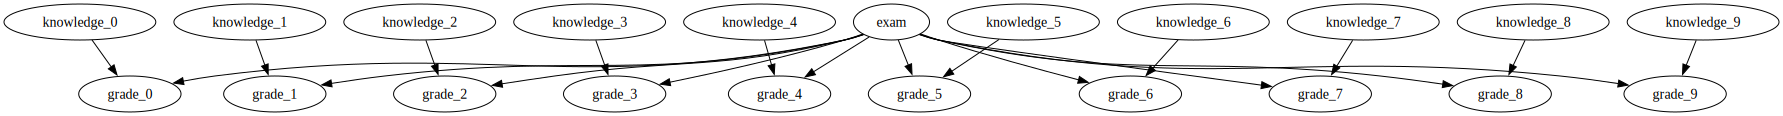

In [59]:
pyro.render_model(describe_grade)

This can work when the number of conditionally independent repetitions is relatively small. Instead, when there are many repetitions, there is a more compact and efficient way to define this behavior: `pyro.plate`

Everything that is defined inside the `pyro.plate` context manager, is automatically vectorized and conditionally independent:

In [60]:
def describe_grade_plate():
    difficulty = pyro.sample("exam", dist.Bernoulli(0.5))
            
    with pyro.plate("N", 10):
        knowledge = pyro.sample("knowledge", dist.Bernoulli(0.3))
        mu = 4 * knowledge - 2 * difficulty + 4
        grade = pyro.sample(f"grade", dist.Normal(loc=mu, scale=1))
        
    return grade

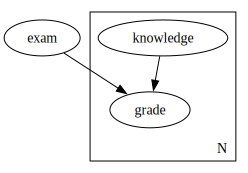

In [61]:
pyro.render_model(describe_grade_plate)

In [62]:
print("grades: ", describe_grade_plate())

grades:  tensor([2.3854, 2.6380, 5.3535, 2.9619, 1.7758, 7.3009, 7.2035, 3.2045, 3.8506,
        5.9843])


Notice that the model is the same, but the graphical model uses the plate notation to represent conditionally independent variables.

Here we show an example were the grades are observed (the problem here could be to infer the knowledge of each student or the difficulty of the exam):

In [63]:
def describe_grade_plate(observed_grades):
    difficulty = pyro.sample("exam", dist.Bernoulli(0.5))
            
    with pyro.plate("N", len(observed_grades)):
        knowledge = pyro.sample("knowledge", dist.Bernoulli(0.3))
        mu = 4 * knowledge - 2 * difficulty + 4
        grade = pyro.sample(f"grade", dist.Normal(loc=mu, scale=1), obs=observed_grades)
        
    return grade

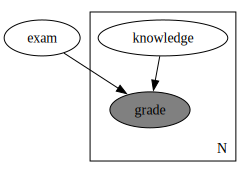

In [65]:
observed_grades = torch.tensor([5.0, 6.0, 7.0, 8.0, 9.0])

pyro.render_model(describe_grade_plate, model_args=(observed_grades, ))

There is also another option for dealing with multiple samples: sampling arrays.

grades:  tensor([6.0917, 4.7967, 5.6562, 8.1806, 8.6317, 4.4353, 8.8433, 8.5904, 2.2256,
        7.7272])


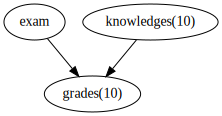

In [23]:
def describe_grade_array(n: int):
    difficulty = pyro.sample("exam", dist.Bernoulli(0.5))
    knowledge = pyro.sample(f"knowledges({n})", dist.Bernoulli(0.3), sample_shape=(n,))
    mu = 4 * knowledge - 2 * difficulty + 4
    grade = pyro.sample(f"grades({n})", dist.Normal(loc=mu, scale=1))
        
    return grade

print("grades: ", describe_grade_array(10))
    
pyro.render_model(describe_grade_array, model_args=(10, ))

But the graphical model is not really transparent! This graph doesn't contain the information that each couple (knowledge, grade) is conditionally independent from others.

Anyway, we can use the plate or arrays allows to sample in a more efficiet way:

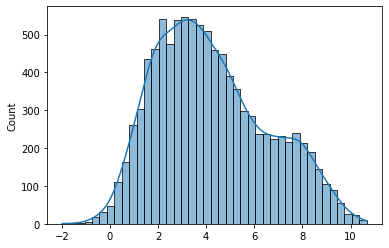

In [24]:
def describe_grade_array(n: int):
    difficulty = pyro.sample("exam", dist.Bernoulli(0.5), sample_shape=(n,))
    knowledge = pyro.sample(f"knowledges({n})", dist.Bernoulli(0.3), sample_shape=(n,))
    mu = 4 * knowledge - 2 * difficulty + 4
    grade = pyro.sample(f"grades({n})", dist.Normal(loc=mu, scale=1))
        
    return grade

grades = describe_grade_array(10000)
_ = sns.histplot(grades, kde=True)

### Parameters

Pyro supports also the definition of (named) parameters, that sometimes appear when defining a model.
For example, they are used when defining a prametric model and we are interested in fitting it to observed data by maximum likelihood estimation (MLE). However, these are not used when following a purely probabilistic (bayesian) approach. 

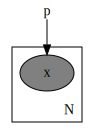

In [25]:
import pyro.distributions.constraints as constraints

def parametric_model(obs):
    p = pyro.param(name='p',
                   init_tensor=torch.tensor(0.5),
                   constraint=constraints.unit_interval)
    with pyro.plate("N"):
        x = pyro.sample("x", dist.Bernoulli(p), obs = obs, constraint = constraints.unit_interval)
    return x

obs = torch.tensor([0,0,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1]).float()
pyro.render_model(parametric_model, render_params=True, model_args=(obs,))

Notice that we can specify the bounds of a parameter: `constraint=constraints.unit_interval`. This information will be exploited during optimization.

### A funny behavior...

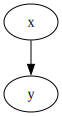

In [66]:
def parametric_model(obs_x=None, obs_y=None):
    x = pyro.sample("x", dist.Bernoulli(0.2), obs=obs_x)
    y = pyro.sample("y", dist.Bernoulli(0.6*x), obs=obs_y).item()
    
pyro.render_model(parametric_model)

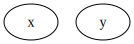

In [67]:
def parametric_model(obs_x=None, obs_y=None):
    x = pyro.sample("x", dist.Bernoulli(0.2), obs=obs_x).item()
    y = pyro.sample("y", dist.Bernoulli(0.6*x), obs=obs_y).item()
    
pyro.render_model(parametric_model)

### Summary

Now we can consider probabilistic models, represented by a standard graphical notation and convert them in Pyro models with the following primitive functions:

- latent random variables -> **pyro.sample**
- observed random variables -> **pyro.sample** with **obs** keyword argument
- plates (sets of conditionally independent variables) -> **pyro.plate**
- learnable parameters -> **pyro.param**

For example, we can write the model in the image above assuming the following distibutions:

- $\alpha \sim Normal(2,1)$
- $\beta \sim Normal(1,1)$
- $\sigma_y \sim HalfNormal(0.5,1)$ 
- $x_i \sim Normal(0,1)$ with observed data, N independent samples
- $y_i \sim Normal(\alpha * \beta + x, \sigma_y)$ with observed data, N independent samples

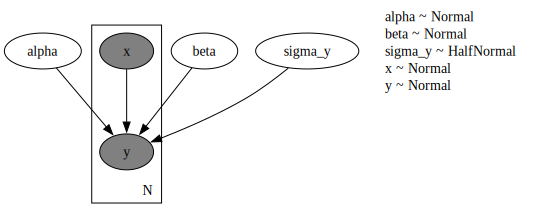

In [68]:
def parametric_model(x_data, y_data):
    alpha = pyro.sample('alpha', dist.Normal(2,1))
    beta = pyro.sample('beta', dist.Normal(1,1))
    sigma_y = pyro.sample('sigma_y', dist.HalfNormal(0.5,1))
    with pyro.plate("N", len(x_data)):
        x = pyro.sample("x", dist.Normal(0,1), obs=x_data)
        pyro.sample("y", dist.Normal(alpha*beta + x, sigma_y), obs=y_data)

# OBSERVED DATA
data_x = torch.tensor((0, 0.2, 0.1, 0.3, 0, 0.1, 0.2, -0.1, -0.3, 0))
data_y = torch.tensor((2,3,2.5,1.5,0,1.5,1,2.3,3,2.8))

# VISUALIZE THE MODEL
pyro.render_model(parametric_model, model_args=(data_x,data_y,), render_params=True ,render_distributions=True)